In [1]:
# A notebook for organising AI progress metrics

from datetime import date
from IPython.core.debugger import Tracer

# We have the following structures:
#
# problem 
#     \   \
#      \   metrics  -  measures 
#       \
#        - subproblems
#             \
#           metrics
#              \
#             measures
#
# problems are tagged with attributes:
# eg, vision, abstract-games, language, world-modelling, safety
#     agi       -- most capable humans can do this, so AGIs can do this
#     super     -- the very best humans can do this, or human organisations have solved this
#     verysuper -- neither humans nor human orgs have solved this
#
# problems can have "subproblems", including simpler cases and preconditions
#
# a "metric" is one way of measuring progress on a problem. There will often be several metrics
# for a given problem, but in some cases we'll start out with zero metrics and will need to start
# proposing some...
#
# a measure[ment] is a score on a given metric, by a particular codebase/team/project, at a particular
# time

problems = {}
metrics = {}
measurements = set() # we don't try to guarantee unique names for these, so use a set
all_attributes = set()

class Problem:
    def __init__(self, name, attributes=[], solved=False, url=None):
        self.name = name
        self.attributes = attributes
        for a in attributes:
            global all_attributes
            all_attributes.add(a)
        self.subproblems = []
        self.superproblems = []
        self.metrics = []
        self.solved = solved
        self.url = url
        global problems, metrics
        problems[name] = self
        
    def subproblem(self, other_problem):
        self.superproblems.append(other_problem)
        other_problem.subproblems.append(self)
        
    def metric(self, *args, **kwargs):
        m = Metric(*args, **kwargs)
        m.parent = self
        self.metrics.append(m)
        return m
    
    def check_solved(self):
        if all(m.solved for m in self.metrics + self.subproblems):
            self.solved = True
            for p in self.superproblems:
                p.check_solved()


# Different metrics and measurements for progress are made on very different types of scales
# we have some helper functions to regularise these a little bit, so we can tell (for instance)
# whether progress on some metric appears to be accelerating or decelerating.

# Interface:
#    improvement(score1, score2): retrns a consistent measure of how much better score2 is than score1
#    pseudolinear(score): returns a modified version of score where we would expect vaguely linear progress

class Linear:
    def improvement(self, score1, score2):
        return score2 - score1
    def pseudolinear(self, score):
        return score
linear = Linear()

class ELO:
    def improvement(self, score1, score2):
        """
        Normalise an ELO score
        
        An ELO increase of 400 improves your odds by 10x, so we could justify something like
        return 10.0 ** ((score2 - score1)/400.)
        However, it seems that at least for chess ELO progress has been roughly linear over
        time, both for humans and computers (though with different coefficients). Perhaps this
        tracks exponential increases in ability to search the game's state space, driven directly
        by Moore's law on the computer side, and indirectly for humans by access to better training
        tools and more profound libraries of past play.
        
        So for now let's treat this as linear? But ELO is not a chess-specific measure, and in other
        contexts we may want to do exponentiation as documented above?
        """
        return score2 - score1
    def pseudolinear(self, score):
        return score
    
elo = ELO()

class ErrorRate:
    """Many labelling contests use these measures"""
    def improvement(self, score1, score2):
        # 0.5 / 0.25
        return score1 / score2
    def pseudolinear(self, score):
        # The choice of base here is arbitrary. But since this is computer science, let's use base2!
        from math import log
        return log(score) / log(2.0)
error_rate = ErrorRate()

class CorrectRate:
    "100 - error rate"
    def erate(self, score):
        return (100. - score)/100.

    def improvement(self, score1, score2):
        return self.erate(score1) / self.erate(score2)
    
    def pseudolinear(self, score):
        from math import log
        return log(self.erate(score)) / log(2.0)
correct_rate = CorrectRate()
    
class Metric:
    def __init__(self, name, url=None, solved=False, notes="", scale=linear, target=None, parent=None):
        self.name = name
        self.measures = []
        self.solved = solved
        self.url = url
        self.notes = notes
        self.scale = scale
        self.target = target
        global metrics
        metrics[name] = self
        self.parent = parent
        
    def measure(self, *args, **kwargs):
        m = Measurement(*args, **kwargs)
        self.measures.append(m)
        if self.target:
            if self.scale.improvement(self.target, m.value) >= 0:
                self.solved = True
                self.parent.check_solved()
        return m


class Measurement:
    def __init__(self, date, value, name, url, algorithms=[], uncertainty=0, minval=None, maxval=None, opensource=False, replicated=""):
        self.date = date
        self.value = value
        assert isinstance(value, float) or isinstance(value, int), "Measurements on metrics need to be numbers"
        self.name = name
        self.url = url
        self.minval = minval if minval else value - uncertainty
        self.maxval = maxval if maxval else value + uncertainty
        self.opensource = opensource
        self.replicated_url = replicated
        self.algorithms = []
        global measurements
        measurements.add(self)



### Sources to incorporate

* ☑ Jack Clark's collection of progress measurements 
* ☐ Sarah Constantin's [Performance Trends in AI](https://srconstantin.wordpress.com/2017/01/28/performance-trends-in-ai/)
* ☐ Katja Grace's [Algorithmic Progress in Six Domains](https://intelligence.org/files/AlgorithmicProgress.pdf)

In [2]:
# BEGIN ACTUALLY CLASSIFYING PROBLEMS

scene_description = Problem("Scene description", ["agi", "vision", "language", "world-modelling"])
image_classification = Problem("Image classification", ["vision", "agi"])
scene_description.subproblem(image_classification)

imagenet = image_classification.metric("imagenet", "http://image-net.org", scale=error_rate)
imagenet.notes = """
Correctly label images from the Imagenet dataset. As of 2016, this includes:
 - Object localization for 1000 categories.
 - Object detection for 200 fully labeled categories.
 - Object detection from video for 30 fully labeled categories.
 - Scene classification for 365 scene categories (Joint with MIT Places team) on Places2 Database http://places2.csail.mit.edu.
 - Scene parsing for 150 stuff and discrete object categories (Joint with MIT Places team).
WARNING: these subchallenges were added in successive years of the Imagenet challenge, so results from years are not directly
comparable; however progress should probably be understated by comparing them?
"""

# Data points gathered by Jack Clark:
imagenet.measure(date(2010,8,31), 0.28191, "NEC UIUC", "http://image-net.org/challenges/LSVRC/2010/results")
imagenet.measure(date(2015,12,10), 0.03567, "MSRA", "http://image-net.org/challenges/LSVRC/2015/results", algorithms=["residual-networks"])

"""
** 2010: 0.28191**
**NEC UIUC**
http://image-net.org/challenges/LSVRC/2010/results

** 2011: 0.25770
 XRCE**

** 2012: 0.16422**
** Supervision**
http://image-net.org/challenges/LSVRC/2012/results.html

** 2013: 0.11743 **
**Clarifai**
http://www.image-net.org/challenges/LSVRC/2013/results.php

** 2014: 0.07405**
**VGG**
http://image-net.org/challenges/LSVRC/2014/index
 

**2015: 0.03567**
**MSRA**
http://image-net.org/challenges/LSVRC/2015/results

** 2016: 0.02991**
**Trimps-Soushen**
http://image-net.org/challenges/LSVRC/2016/results
* * *
"""
None

In [3]:
# Abstract games like chess, go, checkers etc can be played with no knowldege of the human world.
# Although this domain has largely been solved to super-human performance levels, there are a
# few ends that need to be tied up, especially in terms of having agents learn rules for arbitrary 
# abstract games effectively

abstract_strategy_games = Problem("Abstract strategy games", ["agi", "abstract-games"])

playing_with_hints = Problem("Playing abstract games with extensive hints", ["abstract-games"], solved=True)
playing_with_hints.notes = """
  Complex abstract strategy games have been solved to super-human levels
  by computer systems with extensive rule-hinting and heuristics,
  in some cases combined with machine learning techniques.
"""
computer_chess = playing_with_hints.metric("computer chess", scale=elo)
# For some caveats, see https://en.wikipedia.org/w/index.php?title=Chess_engine&oldid=764341963#Ratings
computer_chess.measure(date(2017,02,27), 3393, "Stockfish", uncertainty=50,
                           url="https://web.archive.org/web/20170227044521/http://www.computerchess.org.uk/ccrl/4040/")
computer_chess.measure(date(1997,05,11), 2725, "Deep Blue", uncertainty=25,
                           url="https://www.quora.com/What-was-Deep-Blues-Elo-rating")

mastering_historical_games = Problem("Mastering human abstract strategy games", ["super", "abstract-games"])
mastering_chess = mastering_historical_games.metric("mastering chess")
mastering_chess.notes = """
  Beating all humans at chess, given a corpus of past play amongst masters,
  but no human-crafted policy constraints and heuristics. This will probably fall out
  immediately once learning_abstract_game_rules is solved, since playing_with_hints
  has been solved.
"""

# Are there any published metrics for these yet?
learning_abstract_game_rules = Problem("Learning the rules of complex strategy games from examples", ["agi", "abstract-games"])
learning_chess = learning_abstract_game_rules.metric("learning chess")
learning_chess.notes = """
  Chess software contains hard-coded policy constraints for valid play; this metric is whether RL
  or other agents can correctly build those policy constraints from examples or oracles"""
learning_go = learning_abstract_game_rules.metric("learning go")
learning_go.notes = """
  Go software contains policy constraints for valid play and evaluating the number of
  liberties for groups. This metric is whether RL or other agents can correctly build those 
  policy constraints from examples or oracles"""
learning_arbitrary_abstract_games = Problem("Play an arbitrary abstract game, first learning the rules", ["agi", "abstract-games"])
                           


In [4]:
# Speech recognition

"""
        http://melodi.ee.washington.edu/s3tp/

* * *
**_Word error rate on Switchboard (specify details): [Month, Year: Score [SWB]: Team].  Compiled by Jack Clark._**

A note about measurement: We're measuring Switchboard (SWB) and Call Home (CH) performance from the Hub5'00 dataset, with main scores assesses in terms of word error rate on SWB. We also create 

Why do we care: Reflects the improvement of audio processing systems on speech over time.

"""
speech_recognition = Problem(name="Speech Recognition", attributes=["language", "agi"])
switchboard_metric = speech_recognition.metric(name="Word error rate on Switchboard",
                                               scale=error_rate, target=0.0)
switchboard_metric.measure(date=date(2011,8,31), value=16.1,
                           name="Conversational Speech Transcription Using Context-Dependent Neural Networks",
                           url="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/CD-DNN-HMM-SWB-Interspeech2011-Pub.pdf")
switchboard_metric.measure(date=date(2012,4,27), value=18.5,
                           name="Deep Neural Networks for Acoustic Modeling in Speech Recognition",
                           url="https://pdfs.semanticscholar.org/ce25/00257fda92338ec0a117bea1dbc0381d7c73.pdf?_ga=1.195375081.452266805.1483390947")
switchboard_metric.measure(date=date(2013,1,1), value=12.9,
                           name="Sequence discriniative training of deep neural networks",
                           url="http://www.danielpovey.com/files/2013_interspeech_dnn.pdf")
switchboard_metric.measure(date=date(2014,6,30), value=16, 
                           name="Increasing Deep Neural Network Acoustic Model Size for Large Vocabulary Continuous Speech Recognition",
                           url="https://arxiv.org/abs/1406.7806v1")
switchboard_metric.measure(date=date(2014,12,7), value=20,
                           name="Deep Speech", url="https://arxiv.org/abs/1412.5567")
switchboard_metric.measure(date=date(2014,12,7), value=12.6,
                           name="Deep Speech", url="https://arxiv.org/abs/1412.5567")
switchboard_metric.measure(date=date(2015,5,21), value=8.0,
                           name="The IBM 2015 English Conversational Telephone Speech Recognition System",
                           url="https://arxiv.org/abs/1505.05899")
switchboard_metric.measure(date=date(2016,4,27), value=6.9,
                           name="The IBM 2016 English Conversational Telephone Speech Recognition System",
                           url="https://arxiv.org/abs/1604.08242v1")
switchboard_metric.measure(date=date(2017,2,17), value=6.9,
                           name="Microsoft 2016 Conversational Speech Recognition System",
                           url="https://arxiv.org/abs/1609.03528")
switchboard_metric.measure(date=date(2017,2,17), value=6.2,
                           name="Microsoft 2016 Conversational Speech Recognition System",
                           url="https://arxiv.org/abs/1609.03528")
switchboard_metric.measure(date=date(2016,10,17), value=6.6,
                           name="Achieving Human Parity in Conversational Speech Recognition",
                           url="https://arxiv.org/abs/1610.05256")
switchboard_metric.measure(date=date(2016,10,17), value=5.9,
                           name="Achieving Human Parity in Conversational Speech Recognition",
                           url="https://arxiv.org/abs/1610.05256")

<__main__.Measurement instance at 0x7f659e700758>

In [5]:
# Image Generation

""" 
* * *
**_Generative models of CIFAR-10 Natural Images _****[Year: bits-per-subpixel, method]. Compiled by Durk Kingma.**

**Why we care:**
(1) The compression=prediction=understanding=intelligence view (see Hutter prize, etc.). (Note that perplexity, log-likelihood, and #bits are all equivalent measurements.)
(2) Learning a generative model is a prominent auxiliary task towards semi-supervised learning. Current SOTA semi-supervised classification results utilize generative models.
3) You're finding patterns in the data that let you compress it more efficiently. Ultimate pattern recognition benchmark because you're trying to find the patterns in all the data. 

"""

image_generation = Problem("Generative models of CIFAR-10 Natural Images", ["vision", "agi"])
# note: this section is not on scene generation, but making the distinction seemed like a good idea.
scene_generation = Problem("Be able to generate complex scene e.g. a baboon receiving their degree at convocatoin.", ["vision", "world-modelling", "agi"])
scene_generation.subproblem(image_generation)

# Note: scale, and target need to be checked
image_generation_metric = image_generation.metric(name="bits-per-subpixel", solved=False, scale=error_rate, target=1.0)

image_generation_metric.measure(date=date(2014,10,30), value=4.48, name="NICE", url="https://arxiv.org/abs/1410.8516")
image_generation_metric.measure(date=date(2015,2,16), value=4.13, name="DRAW", url="https://arxiv.org/abs/1502.04623")
image_generation_metric.measure(date=(2016,5,27), value=3.49, name="Real NVP", url="https://arxiv.org/abs/1605.08803")
image_generation_metric.measure(date=2016, value=3.11, name="VAE with IAF", url="https://papers.nips.cc/paper/6581-improved-variational-inference-with-inverse-autoregressive-flow")
image_generation_metric.measure(date=date(2016,5,27), value=3.0, name="PixelRNN", url="https://arxiv.org/abs/1605.08803")
image_generation_metric.measure(date=date(2016,11,4), value=2.92, name="PixelCNN++", url="https://openreview.net/forum?id=BJrFC6ceg")


<__main__.Measurement instance at 0x7f659e6c15a8>

We should add an English text compression metric here. Shannon's [classic 1951 paper]() obtained an expiermental measure of human text compression performance at 0.6 - 1.3 bits per character. More recent work ([Moradi 1998](https://pdfs.semanticscholar.org/48bc/ce35ceb72068723d5f360f388a073aadadca.pdf), Cover 1978) provides estimates that are text-relative and in the 1.3 bits per character (and for some texts, much higher) range.

In [6]:
"""
**_Perplixity on Penn Treebank [Year, perplexity score]. Compiled by Jack._**
**Why do we care: **perplexity gives us a sense of how well the computer has been able to model language. Lower perplexity indicates less confusion on the part of the model about what language to use to complete a sentence. 

 2012: 124.7
mikolov & zweig
https://pdfs.semanticscholar.org/04e0/fefb859f4b02b017818915a2645427bfbdb2.pdf

 2013: 107.5
pascanu test
how to construct deep RNNs, https://arxiv.org/abs/1312.6026

 2014: 78.4, validation: 82.2
zaremba et all.
https://arxiv.org/abs/1409.2329

 2015: test: 73.4
 variational LSTM (large, untied, MC)
https://arxiv.org/pdf/1512.05287v5.pdf

 2016: test: 70.9
pointer sentinel-lstm
https://arxiv.org/pdf/1609.07843v1.pdf

 2016: test: 66
 recurrent highway networks
https://arxiv.org/pdf/1607.03474v3.pd (https://arxiv.org/pdf/1607.03474v3.pdf)
"""
penn_treebank_perplexity = Problem("Perplexity gives us a sense of how well the computer has been able to model language. Lower perplexity indicates less confusion on the part of the model about what language to use to complete a sentence.", ["language", "agi"])


In [7]:
"""
* * *
**_Perplixity on Penn Treebank [Year, perplexity score]. Compiled by Jack._**

**Why do we care: **perplexity gives us a sense of how well the computer has been able to model language. Lower perplexity indicates less confusion on the part of the model about what language to use to complete a sentence. 


 2012: 124.7
mikolov & zweig
https://pdfs.semanticscholar.org/04e0/fefb859f4b02b017818915a2645427bfbdb2.pdf

 2013: 107.5
pascanu test
how to construct deep RNNs, https://arxiv.org/abs/1312.6026

 2014: 78.4, validation: 82.2
zaremba et all.
https://arxiv.org/abs/1409.2329

 2015: test: 73.4
 variational LSTM (large, untied, MC)
https://arxiv.org/pdf/1512.05287v5.pdf

 2016: test: 70.9
pointer sentinel-lstm
https://arxiv.org/pdf/1609.07843v1.pdf

 2016: test: 66
 recurrent highway networks
https://arxiv.org/pdf/1607.03474v3.pd (https://arxiv.org/pdf/1607.03474v3.pdf)
* * *
**_Bits-per-character on enwik8 dataset to measure Hutter Prize compression progression_**
[Year, bits-per-character]. Compiled by Jack

Why we care about this: relationship between compression and intelligence?

2011: 1.60
Paper: Generating text with recurrent neural networks
Url: 
https://www.google.com/search?q=Generating+text+with+recurrent+neural+networks&oq=Generating+text+with+recurrent+neural+networks&aqs=chrome..69i57.196j0j4&sourceid=chrome&ie=UTF-8

**2013:**

2013: 1.67
Paper: Generating sequences with recurrent neural networks
Url: https://arxiv.org/abs/1308.0850

**2015:**

February, 2015: 1.58 
Paper: Gated Feedback Recurrent Neural Networks
Url: https://arxiv.org/abs/1502.02367

July, 2015: 1.47 
Paper:  Grid Long Short-Term Memory
Url: https://arxiv.org/abs/1507.01526

**2016:**

July, 2016: 1.32
Recurrent highway networks
https://arxiv.org/abs/1607.03474

September, 2016:  1.32
Paper: Hierarchical Multiscale Recurrent Neural Networks
Url: https://arxiv.org/abs/1609.01704

September, 2016: 1.39
hypernetworks / hyperlstm
https://arxiv.org/abs/1609.09106

October, 2016: 1.37
Paper: surprisal-driven feedback in recurrent neural networks, 
Url: https://arxiv.org/pdf/1608.06027.pdf

2016 - surprisal driven zoneout, test: 1.313
https://pdfs.semanticscholar.org/e9bc/83f9ff502bec9cffb750468f76fdfcf5dd05.pdf?_ga=1.27297145.452266805.1483390947

**Human/Algo best performance:**

**cmix v11, test 1.245 BPC**
CMIX (SOTA) uses neural nets. Both LSTM and fully connected. Uses 1,746 independent models, majority of which come from other OSS compression progs eg paq8l, paq8pxd, paq8hp12
 http://www.byronknoll.com/cmix.html
"""
None

In [8]:
reading_comprehension = Problem("Language comprehension and question-answering", ["language", "world-modelling", "agi"])

bAbi = reading_comprehension.metric("bAbi", url="http://fb.ai/babi", scale=correct_rate, target=99)
bAbi.notes = """
A synthetic environment inspired by text adventures and SHRDLU, which enables generation
of ground truths, describing sentences, and inferential questions. Includes:
supporting facts, relations, yes/no questions, counting, lists/sets, negation, indefiniteness,
conference, conjunction, time, basic deduction and induction, reasoning about position, size,
path finding and motivation.

Table 3 of https://arxiv.org/abs/1502.05698 actually breaks this down into 20 submeasures
but initially we're lumping all of this together.

Originally "solving" bABI was defined as 95% accuracy (or perhaps) 95% accuracy on all submeasures,
but clearly humans and now algorithms are better than that.

TODO: bAbi really needs to be decomposed into semi-supervised and unsupervised variants, and 
by amount of training data provided
"""
bAbi.measure(date(2015,2,19),  93.3, "MemNN-AM+NG+NL",  "https://arxiv.org/abs/1502.05698")
bAbi.measure(date(2015,3,31),  93.4, "MemN2N-PE+LS+RN", "https://arxiv.org/abs/1503.08895")
bAbi.measure(date(2015,6,24),  93.6, "DMN",             "https://arxiv.org/abs/1506.07285")
bAbi.measure(date(2016,1,5),   96.2, "DNC",             "https://www.gwern.net/docs/2016-graves.pdf")
bAbi.measure(date(2016,6,30),  97.2, "DMN+",            "https://arxiv.org/abs/1607.00036")
bAbi.measure(date(2016,9,27),  97.1, "SDNC",            "https://arxiv.org/abs/1606.04582v4")
bAbi.measure(date(2016,12,12), 99.5, "EntNet",          "https://arxiv.org/abs/1612.03969")
bAbi.measure(date(2016,12,9),  99.7, "QRN",             "https://arxiv.org/abs/1606.04582v4")
print "How is bAbi solved?", bAbi.solved

"""

* * *
**_Task completion and average error score for Facebook's BAbI dataset to measure limited question answering. Compiled by Jack._**
[Year, failed tasks#, mean error%, paper]
 
[note: a task is defined as failed if error is higher than 5%. Mean error is error across all tasks ]

**Why we care about this:** helps us understand how well AI can be trained to deduce facts from a large dataset corpus. 
(Measurement note - the pathfinding and positional reasoning Qs are much harder for AI than other qs, so watching this perf improve is significant)

February, 2015:
Failed tasks: 4
Mean error: 8%
Paper: Towards ai-complete question answering: a set of prerequisite toy tasks 
Url: https://arxiv.org/abs/1502.05698

March, 2015: 
Failed tasks: 4
Mean error: 7.2%
(MemNN WSH) 39.2 / 17 < find out what WSH means 
(Strongly supervised MemNN) 3.2 / 2 
Paper: End-to-end memory networks 
Url: https://arxiv.org/abs/1503.08895

June, 2015:
Failed tasks: 2
Mean error: 6.4%
Paper: Ask me anything dynamic memory networks for natural language processing (v1)
Url: https://arxiv.org/abs/1506.07285

January, 2016: 
Failed tasks: 2
Mean error: 4.3%
Paper:  Hybrid computing using a neural network with dynamic external memory
Url: http://www.nature.com/nature/journal/v538/n7626/full/nature20101.html#tables

June, 2016 
Failed tasks: 1
Mean error: 2.81%
Paper: Dynamic Neural Turing Machine with Soft and Hard Addressing Schemes
Url: https://arxiv.org/pdf/1607.00036.pdf

2016, October - scaling memory-augmented neural networks with sparse read and writes 
https://arxiv.org/pdf/1610.09027v1.pdf

November, 2016:
Failed tasks: 2
Mean error: 3.7%
Paper: gated end-to-end memory networks
Url: https://arxiv.org/pdf/1610.04211.pdf

December, 2016: 
Failed tasks: 0 
Mean error: 0.5%
Paper:  tracking the world state with recurrent entity networks
Url: https://arxiv.org/abs/1612.03969

Feb, 2017:
Failed tasks: 0
Mean error: 0.3%
Paper:  Query-Reduction Networks for Question Answering v5 
Url: https://arxiv.org/abs/1606.04582

"""
("How is bAbi solved?", bAbi.solved)

# More papers:
# https://www.aclweb.org/anthology/D/D13/D13-1020.pdf

How is bAbi solved? True


('How is bAbi solved?', True)

In [9]:
# Safety problems!

adversarial_examples = Problem("Resistance to adversarial examples", ["safety", "agi"], url="https://arxiv.org/abs/1312.6199")

adversarial_examples.notes = """
We know that humans have significant resistance to adversarial examples.  Although methods like camouflage sometimes
work to fool us into thinking one thing is another, those
"""

# This section is essentially on teaching ML systems ethics and morality. Amodei et al call this "scaleable supervision".

cirl = Problem("Cooperative inverse reinforcement learning of objective functions", ["safety", "agi"])



safe_exploration = Problem("Safe exploration", ["safety", "agi"])
safe_exploration.notes = """
Sometimes, even doing something once is catastrophic. In such situations, how can an RL agent or some other AI system
learn about the catastrophic consequences without even taking the action once?
"""


# Measurements

In [10]:
print "Included thus far:"
print "================================="
print len(problems), "problems"
print len(metrics), "metrics"
print len(measurements), "measurements"
print "=================================\n"
print "Problems by Type:"
print "================================="

by_attr = {}
solved_by_attr = {}
for a in all_attributes:
    print a, len([p for p in problems.values() if a in p.attributes]), "solved:", len([p for p in problems.values() if p.solved and a in p.attributes])


Included thus far:
15 problems
8 metrics
30 measurements

Problems by Type:
agi 13 solved: 1
language 4 solved: 1
world-modelling 3 solved: 1
safety 3 solved: 0
abstract-games 5 solved: 1
super 1 solved: 0
vision 4 solved: 0


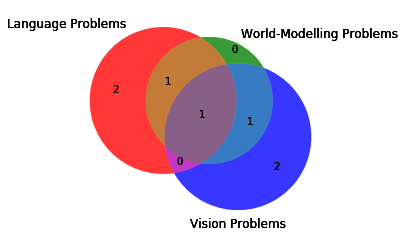

In [13]:
lang = set(p for p in problems.values() if "language" in p.attributes)
world = set(p for p in problems.values() if "world-modelling" in p.attributes)
vision = set(p for p in problems.values() if "vision" in p.attributes)

from matplotlib_venn import venn3
from matplotlib import pyplot as plt
venn3((lang, world, vision), ('Language Problems', 'World-Modelling Problems', 'Vision Problems'))
plt.show()